<a href="https://colab.research.google.com/github/abuelnasr0/Cifar10-transfer-learning/blob/main/Transfer_learning_VS_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import keras
from keras.datasets import cifar10
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load The dataset

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Plot Data examples

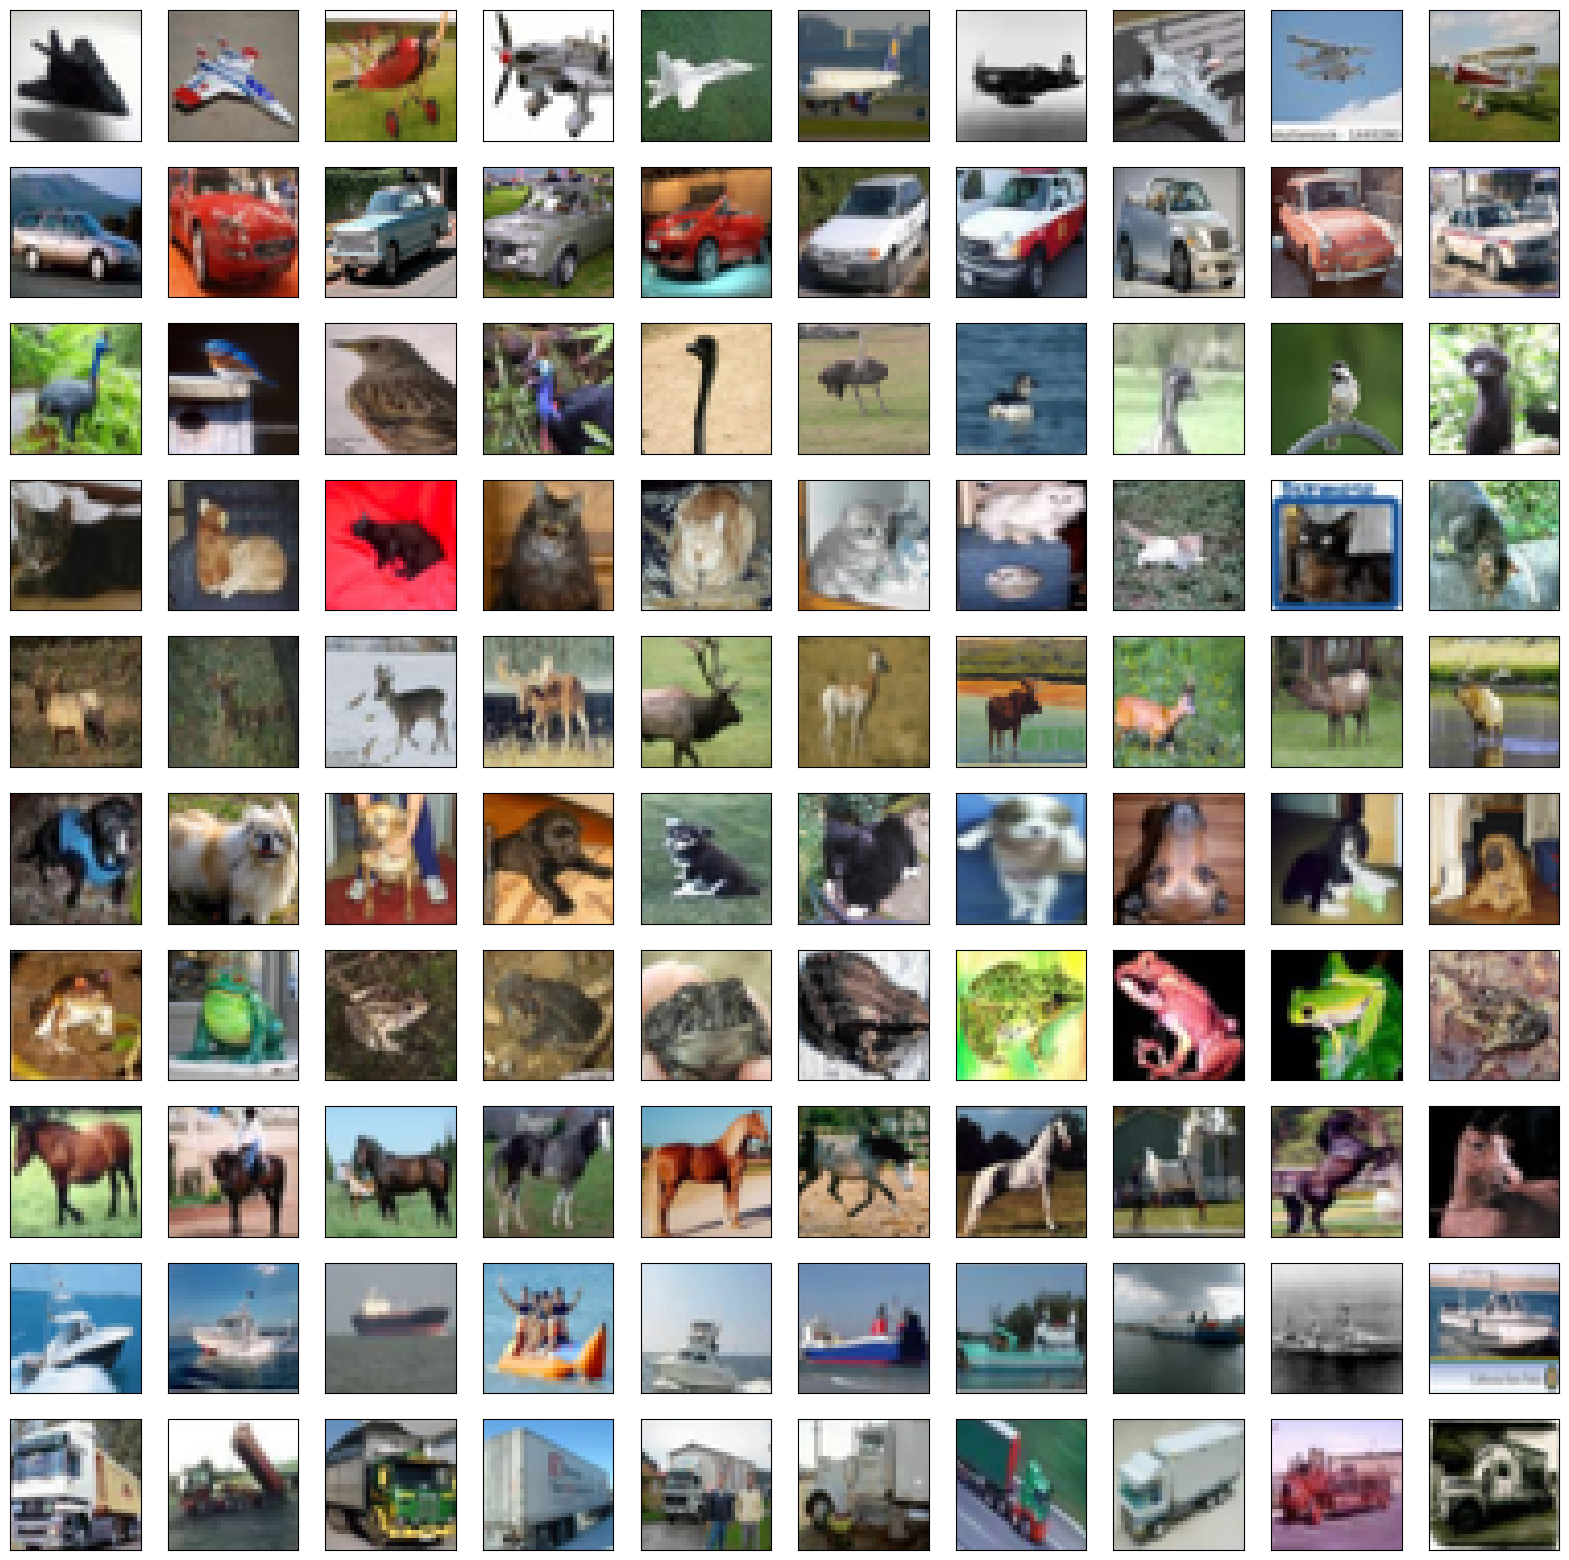

In [6]:
fig = plt.figure(figsize=(20,20))
for label in range(10):
  for example in range(10):
    fig.add_subplot(10, 10, 1 + example + label*10, xticks=[], yticks=[])
    plt.imshow(x_train[np.where(y_train == label)[0]][example])
plt.show()

## Data set Normalization

In [7]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Train CNN model from scratch

## Build The model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(32,32,3)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(10, activation='softmax'))

In [9]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [80]:
CNN_model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## CNN Model Training

In [81]:
history = CNN_model.fit(
          x_train, y_train ,epochs=20, batch_size = 64,
          validation_data=(x_test,y_test))

Epoch 1/20
782/782 [==============================] - 7s 5ms/step - loss: 1.6738 - accuracy: 0.3949 - val_loss: 1.5034 - val_accuracy: 0.4621
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1.2564 - accuracy: 0.5551 - val_loss: 1.1476 - val_accuracy: 0.5833
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1.0673 - accuracy: 0.6263 - val_loss: 1.1999 - val_accuracy: 0.5982
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 0.9433 - accuracy: 0.6694 - val_loss: 0.9275 - val_accuracy: 0.6739
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 0.8499 - accuracy: 0.7038 - val_loss: 1.1089 - val_accuracy: 0.6378
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 0.7744 - accuracy: 0.7306 - val_loss: 1.2450 - val_accuracy: 0.6027
Epoch 7/20
782/782 [==============================] - 4s 6ms/step - loss: 0.7127 - accuracy: 0.7530 - val_loss: 0.9076 - val_accuracy: 0.6891
Epoch 

## Plot Train & Validation history

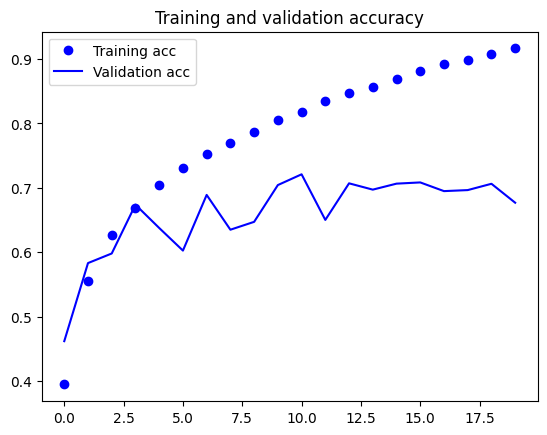

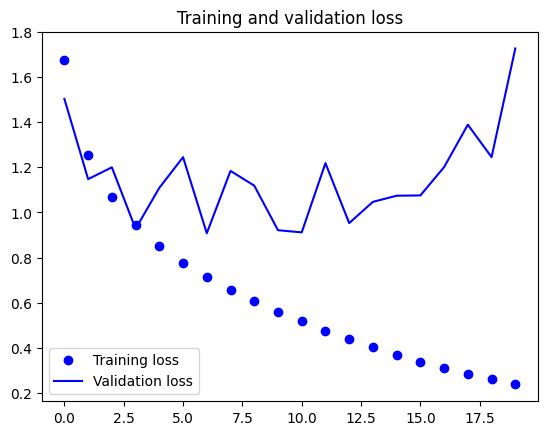

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Plot confusion matrix

313/313 [==============================] - 1s 2ms/step


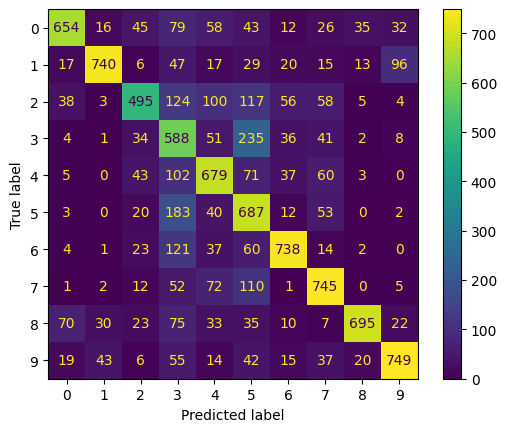

In [83]:
cf_matrix = confusion_matrix(y_test, CNN_model.predict(x_test).argmax(axis=1))
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

# Transfer learning using a pretrained model

## Load the pretrained model and freeze the weights

In [56]:
from keras.applications import VGG19

vgg = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3)
)


In [57]:
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## Add trainable weights in top of the model

In [58]:
vgg_tuned = Sequential()
vgg_tuned.add(vgg)
vgg_tuned.add(Flatten())
vgg_tuned.add(Dense(1024, activation='relu'))
vgg_tuned.add(Dense(512,activation=('relu')))
vgg_tuned.add(Dense(256,activation=('relu')))
vgg_tuned.add(Dense(128,activation=('relu')))
vgg_tuned.add(Dense(10, activation='softmax'))

In [59]:
vgg_tuned.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 1024)              525312    
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 10)               

In [60]:
from keras.optimizers import SGD

learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.5)

vgg_tuned.compile(
    optimizer=sgd,
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

## Model Training

In [61]:
history = vgg_tuned.fit(
          x_train, y_train ,epochs=20, batch_size = 64,
          validation_data=(x_test,y_test))

Epoch 1/20
782/782 [==============================] - 15s 17ms/step - loss: 2.1672 - acc: 0.2617 - val_loss: 2.0149 - val_acc: 0.3277
Epoch 2/20
782/782 [==============================] - 13s 16ms/step - loss: 1.8744 - acc: 0.3744 - val_loss: 1.7599 - val_acc: 0.4055
Epoch 3/20
782/782 [==============================] - 13s 17ms/step - loss: 1.6794 - acc: 0.4248 - val_loss: 1.6170 - val_acc: 0.4411
Epoch 4/20
782/782 [==============================] - 13s 17ms/step - loss: 1.5714 - acc: 0.4533 - val_loss: 1.5391 - val_acc: 0.4603
Epoch 5/20
782/782 [==============================] - 13s 16ms/step - loss: 1.5039 - acc: 0.4716 - val_loss: 1.4841 - val_acc: 0.4802
Epoch 6/20
782/782 [==============================] - 13s 17ms/step - loss: 1.4577 - acc: 0.4879 - val_loss: 1.4427 - val_acc: 0.4911
Epoch 7/20
782/782 [==============================] - 13s 16ms/step - loss: 1.4230 - acc: 0.5006 - val_loss: 1.4137 - val_acc: 0.4995
Epoch 8/20
782/782 [==============================] - 13s 16ms

## Plot history

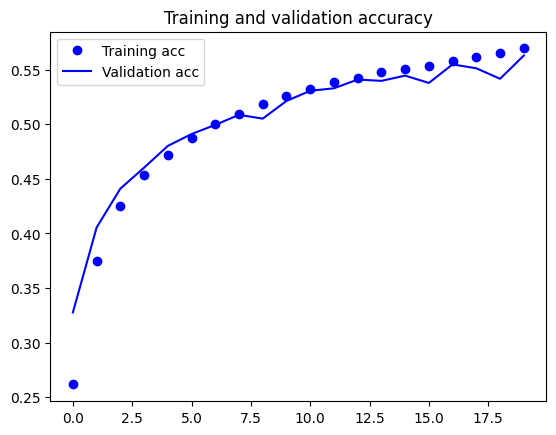

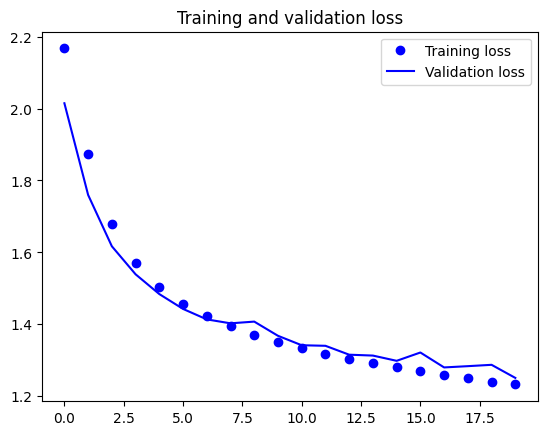

In [62]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

313/313 [==============================] - 3s 9ms/step


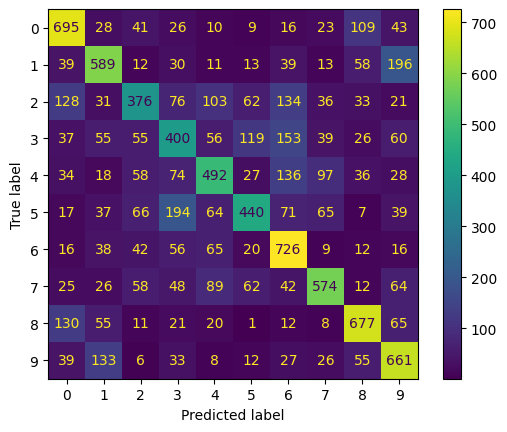

In [78]:
cf_matrix = confusion_matrix(y_test, vgg_tuned.predict(x_test).argmax(axis=1))
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()